https://colab.research.google.com/github/MicPie/DepthFirstLearning/blob/master/InfoGAN/DCGAN_MNIST_v5.ipynb#scrollTo=LoHjTjxcESKZ
https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/5f81194dd43910d586578638f83205a3/dcgan_faces_tutorial.ipynb#scrollTo=JBS91Rh4CSMy

In [1]:
import torch
import torchvision

In [2]:
dataset = torchvision.datasets.MNIST(root="./", transform=torchvision.transforms.ToTensor(), download=True)


In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module): # https://github.com/lyeoni/pytorch-mnist-VAE
    def __init__(self):
        super(VAE, self).__init__()

        # prob. encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, 128)
        self.fc_log_var = nn.Linear(256, 128)

        # prob.decoder
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_log_var(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [5]:
device = "cuda"
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(),lr=0.001)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
# Training Loop
losses = []
iters = 0
num_epochs = 20
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        vae.zero_grad()
        real_images = data[0].reshape(-1,784).to(device)
        recon_x, mu, logvar = vae.forward(real_images)
        loss = loss_function(recon_x, real_images, mu, logvar)
        loss.backward()
        optimizer.step()
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     loss.item()))
        losses.append(loss.item())

Starting Training Loop...
[0/20][0/235]	Loss: 139295.2656
[0/20][50/235]	Loss: 51509.1328
[0/20][100/235]	Loss: 51526.9961
[0/20][150/235]	Loss: 49150.7695
[0/20][200/235]	Loss: 47172.4570
[1/20][0/235]	Loss: 47157.0117
[1/20][50/235]	Loss: 43670.8320
[1/20][100/235]	Loss: 40090.6016
[1/20][150/235]	Loss: 39846.6289
[1/20][200/235]	Loss: 39285.0586
[2/20][0/235]	Loss: 38018.1758
[2/20][50/235]	Loss: 36924.7930
[2/20][100/235]	Loss: 36047.4805
[2/20][150/235]	Loss: 36093.6875
[2/20][200/235]	Loss: 35199.7500
[3/20][0/235]	Loss: 34590.3008
[3/20][50/235]	Loss: 33622.8438
[3/20][100/235]	Loss: 33102.2695
[3/20][150/235]	Loss: 32255.0039
[3/20][200/235]	Loss: 32117.0352
[4/20][0/235]	Loss: 31809.4688
[4/20][50/235]	Loss: 30480.9531
[4/20][100/235]	Loss: 31096.8809
[4/20][150/235]	Loss: 32003.2969
[4/20][200/235]	Loss: 31260.4707
[5/20][0/235]	Loss: 31379.6367
[5/20][50/235]	Loss: 30800.4629
[5/20][100/235]	Loss: 29853.7305
[5/20][150/235]	Loss: 30075.3672
[5/20][200/235]	Loss: 29482.8750
[

In [7]:
import torchvision
fixed_noise = torch.randn(64, 128, device=device)
with torch.no_grad():
    img = vae.decoder(fixed_noise).reshape(64,1,28,28)
    grid = torchvision.utils.make_grid(img)


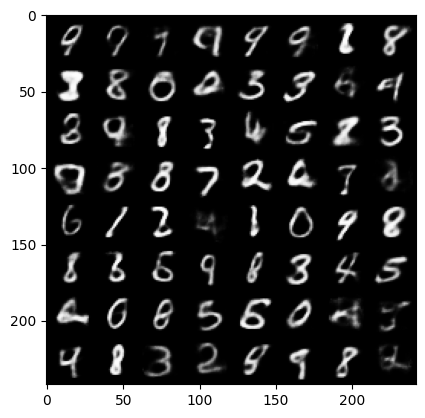

In [8]:
import matplotlib.pyplot as plt
plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

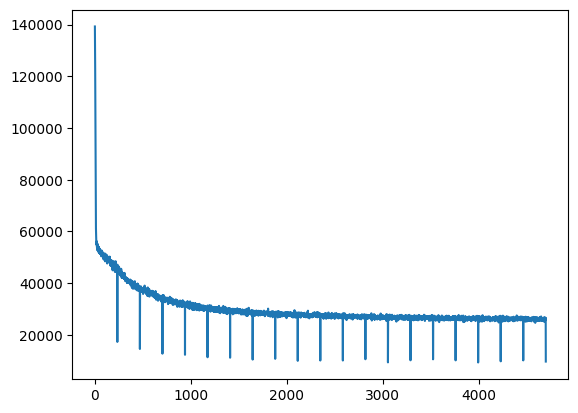

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()